In [1]:
!pip install ucimlrepo scikit-learn tensorflow fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


# Import Libraries and Dataset

In [2]:
# Import necessary libraries
from ucimlrepo import fetch_ucirepo  # Import function for fetching datasets from UCI Machine Learning Repository
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import pandas for data manipulation and analysis
import matplotlib.pyplot as plt  # Import matplotlib for data visualization
import seaborn as sns  # Import seaborn for enhanced data visualization
import time
from fairlearn.metrics import MetricFrame

from sklearn.model_selection import train_test_split  # Import function for splitting data into train and test sets
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # Import scalers for data preprocessing
from sklearn.decomposition import PCA  # Import Principal Component Analysis for dimensionality reduction
from sklearn.manifold import TSNE  # Import t-distributed Stochastic Neighbor Embedding for dimensionality reduction
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, brier_score_loss  # Import evaluation metrics
from sklearn.linear_model import LogisticRegression  # Import Logistic Regression classifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier  # Import Random Forest and Stacking classifiers
from sklearn.naive_bayes import GaussianNB  # Import Gaussian Naive Bayes classifier
from sklearn.neural_network import MLPClassifier  # Import Multi-layer Perceptron (Neural Network) classifier
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.utils.data import DataLoader, TensorDataset

import xgboost as xgb  # Import XGBoost library for gradient boosting
from xgboost import XGBClassifier  # Import XGBoost classifier


In [3]:
# Fetch the CDC Diabetes Health Indicators dataset using the fetch_ucirepo function
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# Extract the feature data (independent variables) and target data (dependent variable) from the fetched dataset
X = cdc_diabetes_health_indicators.data.features  # X contains the feature data
y = cdc_diabetes_health_indicators.data.targets   # y contains the target data

# Combine the feature and target data into a single pandas DataFrame for further analysis
df = pd.concat([X, y], axis=1)

# Print the shape of the combined DataFrame to show the number of rows and columns
print(df.shape)

# Display the first few rows of the combined DataFrame to inspect the dataset
df.head()

(253680, 22)


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0


# Data Exploration

In [4]:
# Display the basic structure of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth              253680 non-null  int64
 15  PhysHlth              253680 non-n

In [5]:
# Summarize the statistical aspects of the dataset
df.describe()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,0.811420,...,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875,0.139333
std,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,0.391175,...,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148,0.346294
min,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000,0.000000
50%,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000,0.000000
75%,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000,0.000000
max,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000,1.000000


In [6]:
# Check for missing values across all columns
df.isnull().sum()

HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
Diabetes_binary         0
dtype: int64

# Feature Analysis

In [7]:

def feature_analysis(feature_name, dataframe, target_variable='Diabetes_binary'):
    """
    Perform detailed analysis of a specified feature in a dataset, including visualization.

    Parameters:
    - feature_name: str, name of the feature column in the dataframe.
    - dataframe: pandas.DataFrame, dataframe containing the data.
    - target_variable: str, name of the target variable column in the dataframe for correlation analysis.
    """

    # Print basic information and description of the specified feature
    print(f"Information about {feature_name}:")
    print(dataframe[feature_name].info())
    print("\nDescription:")
    print(dataframe[feature_name].describe())

    # Calculate and display the correlation between the specified feature and the target variable
    correlation = dataframe[[feature_name, target_variable]].corr().iloc[0,1]
    print(f"\nCorrelation between {feature_name} and {target_variable}: {correlation:.2f}")


    # Exclude the target variable from the correlation calculation
    features = [col for col in dataframe.columns if col != target_variable]

    # Calculate the correlation matrix among all features
    corr_matrix = dataframe[features].corr()

    # Isolate the specified feature's correlations with other features
    feature_corr = corr_matrix[[feature_name]].sort_values(by=feature_name, ascending=False)

    # Plot a heatmap to visualize feature correlations
    plt.figure(figsize=(4, 8))
    sns.heatmap(feature_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation of {feature_name} with other features')
    plt.show()

    # Create subplots for various visualizations
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    # Explicitly convert target_variable to string for plotting
    dataframe_str = dataframe.copy()
    dataframe_str[target_variable] = dataframe_str[target_variable].astype(str)

    # Histogram with target variable overlay
    sns.histplot(data=dataframe_str, x=feature_name, hue=target_variable, multiple='stack', kde=True, ax=axs[0, 0])
    axs[0, 0].set_title(f'Histogram of {feature_name}')

    # Boxplot comparing the feature by the target variable
    sns.boxplot(x=target_variable, y=feature_name, data=dataframe_str, ax=axs[0, 1])
    axs[0, 1].set_title(f'Boxplot of {feature_name} by {target_variable}')

    # Count Plot of the feature with target variable overlay
    sns.countplot(x=feature_name, hue=target_variable, data=dataframe_str, ax=axs[1, 0])
    axs[1, 0].set_title('Count Plot of ' + feature_name)

    # Violin Plot to visualize feature distribution by the target variable
    sns.violinplot(x=feature_name, y=target_variable, data=dataframe_str, ax=axs[1, 1], cut=0)
    axs[1, 1].set_title('Violin Plot of ' + feature_name + ' by ' + target_variable)

    # Ensure a neat layout for the subplots
    plt.tight_layout()
    plt.show()


In [8]:
def check_fairness_and_bias(dataframe, attribute):
    """
    Plots the distribution of the target variable 'Diabetes_binary'
    across different groups of a specified attribute to check for fairness and bias.

    Parameters:
    - dataframe: pd.DataFrame, the dataset containing the attribute and target variable.
    - attribute: str, the name of the attribute to analyze for bias.
    """
    # Check if the attribute exists in the dataframe
    if attribute not in dataframe.columns:
        print(f"The attribute '{attribute}' is not in the dataframe.")
        return

    # Group the data by the attribute and calculate the mean of the target variable
    group_means = dataframe.groupby(attribute)['Diabetes_binary'].mean().reset_index()

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x=attribute, y='Diabetes_binary', data=group_means)
    plt.title(f'Distribution of Diabetes_binary by {attribute}')
    plt.ylabel('Mean of Diabetes_binary')
    plt.xlabel(attribute)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

    # Optionally, you can also plot the count of samples in each group to check for representation
    plt.figure(figsize=(10, 6))
    sns.countplot(x=attribute, data=dataframe)
    plt.title(f'Count of samples by {attribute}')
    plt.xlabel(attribute)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

In [9]:
def fairness_metrics(dataframe, attribute, target='Diabetes_binary'):
    # Split the dataframe into groups based on the attribute
    groups = dataframe.groupby(attribute)

    # Initialize dictionaries to store results
    positive_outcomes_ratio = {}
    demographic_parity_diff = {}
    equality_of_opportunity_diff = {}

    # Get the overall rate of positive outcomes
    overall_positive_rate = dataframe[target].mean()

    for group_name, group_df in groups:
        # Calculate the rate of positive outcomes for each group
        group_positive_rate = group_df[target].mean()

        # Calculate true positive rates for Equality of Opportunity
        true_positive_rate = group_df[group_df[target] == 1][target].mean()

        # Store the results
        positive_outcomes_ratio[group_name] = group_positive_rate / overall_positive_rate
        demographic_parity_diff[group_name] = group_positive_rate - overall_positive_rate
        equality_of_opportunity_diff[group_name] = true_positive_rate - overall_positive_rate

    # Calculate Disparate Impact as the ratio of positive outcomes between the most and least privileged groups
    disparate_impact = min(positive_outcomes_ratio.values()) / max(positive_outcomes_ratio.values())

    # Print results
    print(f"Disparate Impact Analysis (Ideal: 1): {disparate_impact:.4f}")
    for group, ratio in positive_outcomes_ratio.items():
        print(f"Group {group} Positive Outcomes Ratio: {ratio:.4f}")
    print("\nDemographic Parity Differences (Ideal: 0):")
    for group, diff in demographic_parity_diff.items():
        print(f"Group {group}: {diff:.4f}")
    print("\nEquality of Opportunity Differences (Ideal: 0):")
    for group, diff in equality_of_opportunity_diff.items():
        print(f"Group {group}: {diff:.4f}")

    df_copy = dataframe.copy()

    # Convert the target variable to string to ensure it's treated as a categorical variable
    df_copy[target] = df_copy[target].astype(str)

    plt.figure(figsize=(10, 6))
    sns.countplot(x=attribute, hue=target, data=df_copy)
    plt.title(f'Count of samples by {attribute}')
    plt.xlabel(attribute)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.legend(title=target)  # Ensure the legend is properly labeled
    plt.show()

Disparate Impact Analysis (Ideal: 1): 0.8554
Group 0 Positive Outcomes Ratio: 0.9307
Group 1 Positive Outcomes Ratio: 1.0881

Demographic Parity Differences (Ideal: 0):
Group 0: -0.0097
Group 1: 0.0123

Equality of Opportunity Differences (Ideal: 0):
Group 0: 0.8607
Group 1: 0.8607


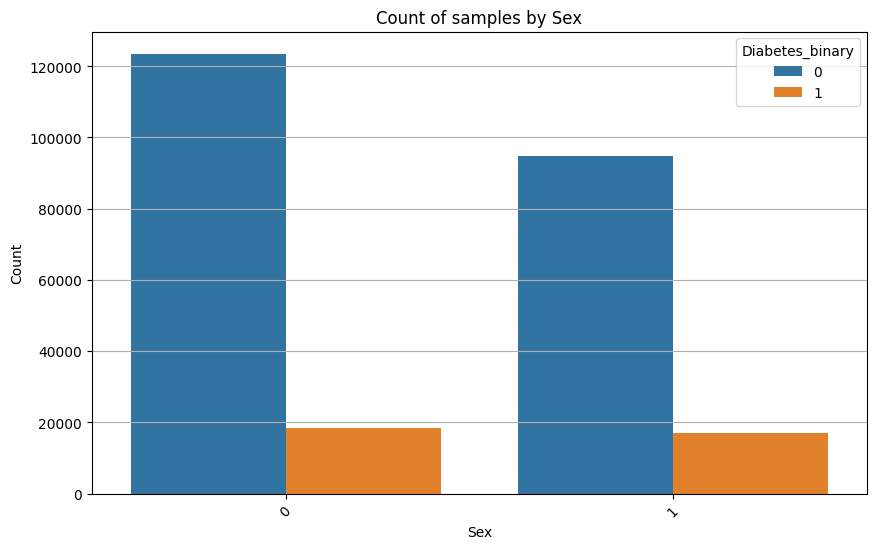

In [10]:
fairness_metrics(df, 'Sex')

Disparate Impact Analysis (Ideal: 1): 0.0626
Group 1 Positive Outcomes Ratio: 0.0982
Group 2 Positive Outcomes Ratio: 0.1322
Group 3 Positive Outcomes Ratio: 0.2026
Group 4 Positive Outcomes Ratio: 0.3250
Group 5 Positive Outcomes Ratio: 0.4669
Group 6 Positive Outcomes Ratio: 0.6308
Group 7 Positive Outcomes Ratio: 0.8422
Group 8 Positive Outcomes Ratio: 0.9923
Group 9 Positive Outcomes Ratio: 1.2377
Group 10 Positive Outcomes Ratio: 1.4620
Group 11 Positive Outcomes Ratio: 1.5679
Group 12 Positive Outcomes Ratio: 1.5284
Group 13 Positive Outcomes Ratio: 1.3265

Demographic Parity Differences (Ideal: 0):
Group 1: -0.1256
Group 2: -0.1209
Group 3: -0.1111
Group 4: -0.0940
Group 5: -0.0743
Group 6: -0.0514
Group 7: -0.0220
Group 8: -0.0011
Group 9: 0.0331
Group 10: 0.0644
Group 11: 0.0791
Group 12: 0.0736
Group 13: 0.0455

Equality of Opportunity Differences (Ideal: 0):
Group 1: 0.8607
Group 2: 0.8607
Group 3: 0.8607
Group 4: 0.8607
Group 5: 0.8607
Group 6: 0.8607
Group 7: 0.8607
Group 

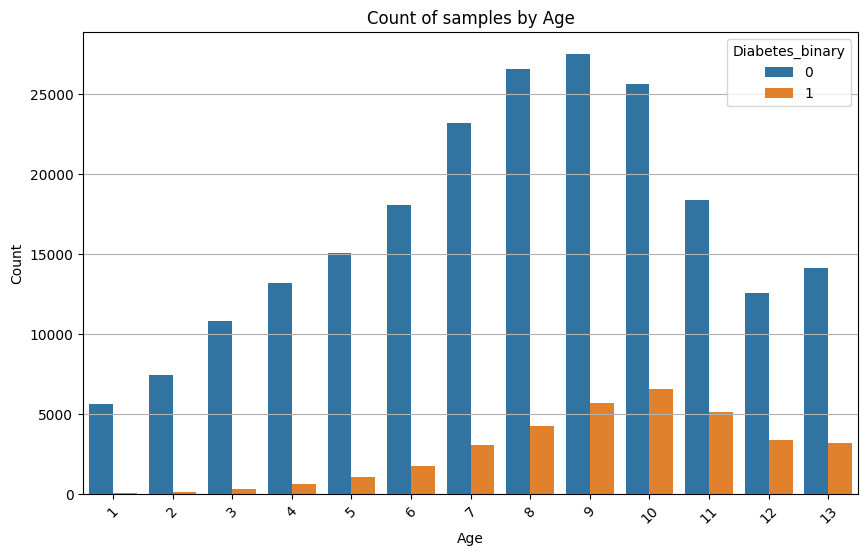

In [11]:
fairness_metrics(df, 'Age')

Disparate Impact Analysis (Ideal: 1): 0.3312
Group 1 Positive Outcomes Ratio: 1.9386
Group 2 Positive Outcomes Ratio: 2.1000
Group 3 Positive Outcomes Ratio: 1.7386
Group 4 Positive Outcomes Ratio: 1.2657
Group 5 Positive Outcomes Ratio: 1.0630
Group 6 Positive Outcomes Ratio: 0.6955

Demographic Parity Differences (Ideal: 0):
Group 1: 0.1308
Group 2: 0.1533
Group 3: 0.1029
Group 4: 0.0370
Group 5: 0.0088
Group 6: -0.0424

Equality of Opportunity Differences (Ideal: 0):
Group 1: 0.8607
Group 2: 0.8607
Group 3: 0.8607
Group 4: 0.8607
Group 5: 0.8607
Group 6: 0.8607


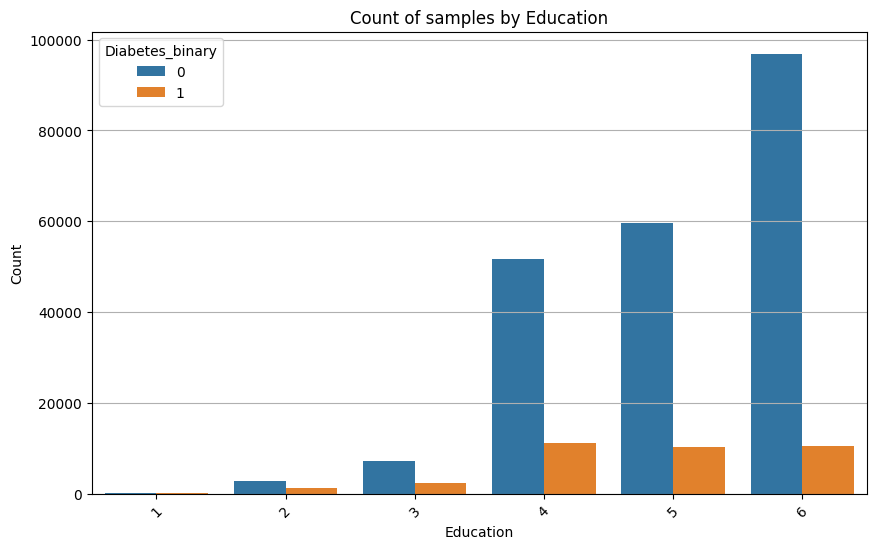

In [12]:
fairness_metrics(df, 'Education')

Disparate Impact Analysis (Ideal: 1): 0.3039
Group 1 Positive Outcomes Ratio: 1.7432
Group 2 Positive Outcomes Ratio: 1.8797
Group 3 Positive Outcomes Ratio: 1.6011
Group 4 Positive Outcomes Ratio: 1.4450
Group 5 Positive Outcomes Ratio: 1.2489
Group 6 Positive Outcomes Ratio: 1.0412
Group 7 Positive Outcomes Ratio: 0.8743
Group 8 Positive Outcomes Ratio: 0.5713

Demographic Parity Differences (Ideal: 0):
Group 1: 0.1036
Group 2: 0.1226
Group 3: 0.0838
Group 4: 0.0620
Group 5: 0.0347
Group 6: 0.0057
Group 7: -0.0175
Group 8: -0.0597

Equality of Opportunity Differences (Ideal: 0):
Group 1: 0.8607
Group 2: 0.8607
Group 3: 0.8607
Group 4: 0.8607
Group 5: 0.8607
Group 6: 0.8607
Group 7: 0.8607
Group 8: 0.8607


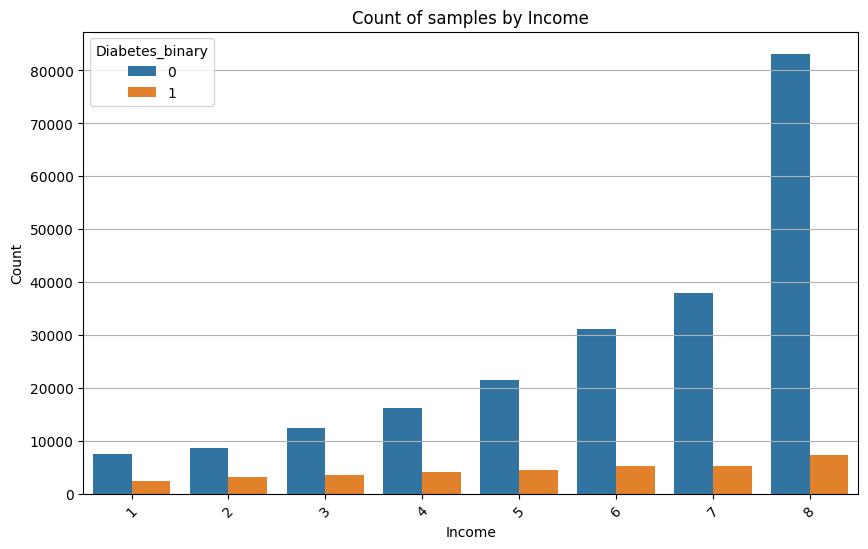

In [13]:
fairness_metrics(df, 'Income')

# Data Preprocessing

In [14]:
# Initialize MinMaxScaler to normalize features
scaler = MinMaxScaler()

# List of columns that you want to scale
columns_to_scale = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']  # Add more columns as needed

# Scale selected columns to bring them into a range between 0 and 1
# df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
df.describe()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,0.811420,...,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875,0.139333
std,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,0.391175,...,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148,0.346294
min,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000,0.000000
50%,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000,0.000000
75%,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000,0.000000
max,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000,1.000000


In [15]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth              253680 non-null  int64
 15  PhysHlth              253680 non-n

# Model Preparation

In [16]:
# Separate Features and Targetr Variable
X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']
column_names = X.columns
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=column_names)

## Principal Component Analysis

In [17]:
feature_names = [
    "HighBP", "HighChol", "CholCheck", "BMI", "Smoker", "Stroke", "HeartDiseaseorAttack",
    "PhysActivity", "Fruits", "Veggies", "HvyAlcoholConsump", "AnyHealthcare", "NoDocbcCost",
    "GenHlth", "MentHlth", "PhysHlth", "DiffWalk", "Sex", "Age", "Education", "Income"
]

Explained variance by component: [0.16713006 0.08396703]
Total variance explained by 2 components: 0.25


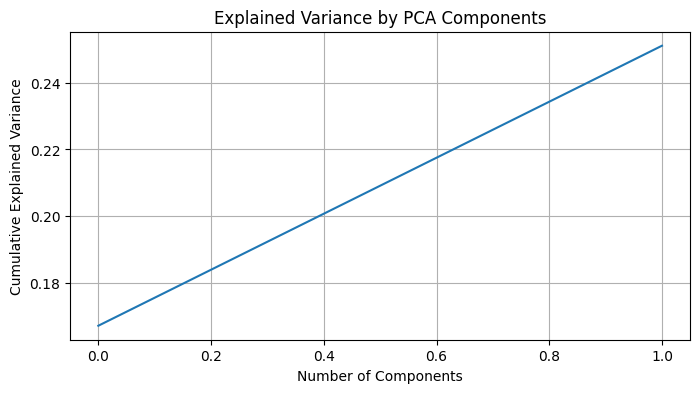

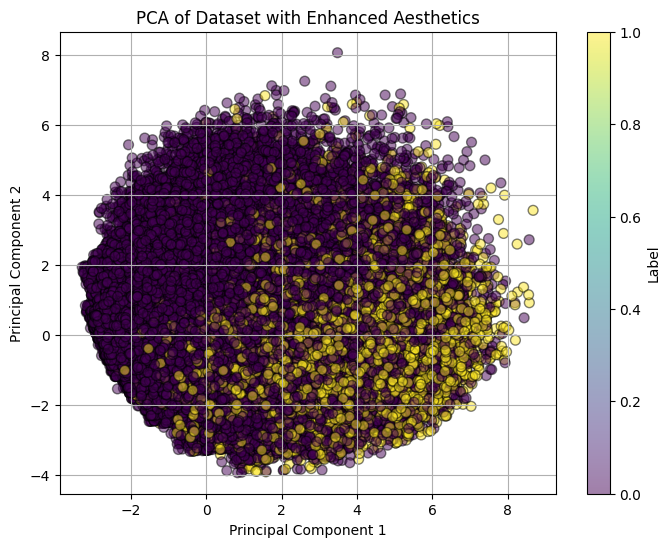

PCA component loadings:
[[ 0.25643764  0.19136386  0.038533    0.17361873  0.15489588  0.16829675
   0.21869481 -0.23725773 -0.10184175 -0.12967988 -0.0272882  -0.04473069
   0.13695096  0.40540668  0.22314099  0.34374283  0.35839658 -0.01860425
   0.17430988 -0.2584124  -0.32032135]
 [-0.32108852 -0.31288289 -0.23960107  0.02156939 -0.0272235  -0.12615762
  -0.23500546 -0.08324979 -0.15967137 -0.12261284  0.03799396 -0.36738554
   0.35563266  0.02959386  0.25509487  0.07611457 -0.01578728 -0.09095927
  -0.46952652 -0.14838087 -0.19016042]]


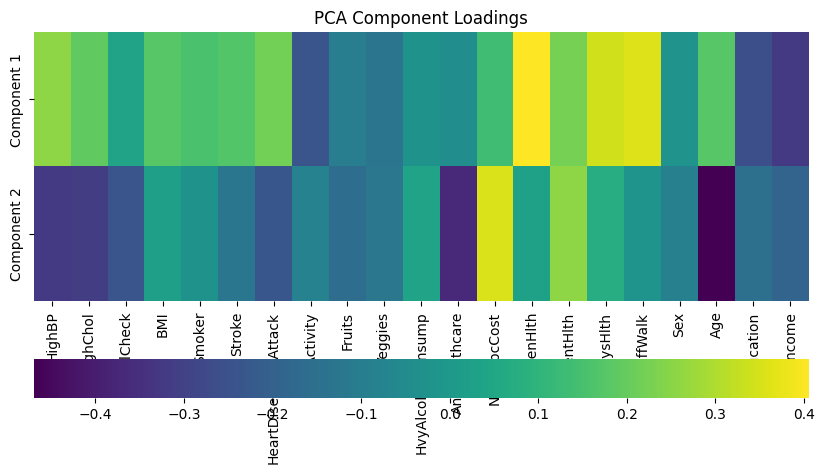

In [ ]:
# Apply PCA
pca = PCA(n_components=2, random_state=24)
X_pca = pca.fit_transform(X_scaled)

# 1. Examine the Explained Variance
print(f"Explained variance by component: {pca.explained_variance_ratio_}")
print(f"Total variance explained by 2 components: {np.sum(pca.explained_variance_ratio_):.2f}")

plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# 2. Visualize the Data
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5, edgecolor='k', s=50)
plt.colorbar(label='Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Dataset with Enhanced Aesthetics')
plt.grid(True)
plt.show()

# 3. Interpret the Components
# This part involves more domain knowledge, but you can start by looking at the components
print("PCA component loadings:")
print(pca.components_)
# Heatmap of component loadings
plt.figure(figsize=(10, 5))
sns.heatmap(pca.components_,
            cmap='viridis',
            yticklabels=[f'Component {i+1}' for i in range(pca.components_.shape[0])],
            xticklabels=feature_names,  # Assuming you have a list of feature names
            cbar_kws={"orientation": "horizontal"})
plt.title('PCA Component Loadings')
plt.show()

# # Alternatively, for a specific component:
component_num = 0  # For the first principal component
plt.figure(figsize=(10, 5))
plt.bar(range(len(pca.components_[component_num])), pca.components_[component_num])
plt.xlabel('Feature')
plt.ylabel('Loading')
plt.title(f'Loadings for Component {component_num+1}')
plt.xticks(range(len(pca.components_[component_num])), feature_names, rotation=90)  # Assuming feature_names is defined
plt.show()

## Train Test Split

In [19]:
# Split the dataset into training and testing sets
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_scaled, y, test_size=0.3, random_state=24)
# Convert back to DataFrame to retain column names
X_train_full_df = pd.DataFrame(X_train_full, columns=X_scaled.columns)
X_test_full_df = pd.DataFrame(X_test_full, columns=X_scaled.columns)

In [20]:
print(f'X_train Shape: {X_train_full.shape} | y_train Shape: {y_train_full.shape}')
print(f'X_test Shape: {X_test_full.shape} | y_test Shape: {y_test_full.shape}')

X_train Shape: (177576, 21) | y_train Shape: (177576,)
X_test Shape: (76104, 21) | y_test Shape: (76104,)


### Define Evaluation Function

In [21]:
# Function to evaluate the performance of a classification model
def evaluate_model(y_true, y_pred):
    """
    Calculate and display common classification metrics for model evaluation.

    Parameters:
    - y_true: array-like, true target values.
    - y_pred: array-like, predicted target values.

    Returns:
    - List of performance metrics [accuracy, precision, recall, F1 score].
    """

    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Print the calculated metrics with four decimal places
    print(f'Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}')

    # Return the metrics as a list
    return [accuracy, precision, recall, f1]

# Stacking Ensemble Model

### Individual Classifiers

In [22]:
# Initialize individual classifiers with hyperparameters

# Logistic Regression Classifier
lr_classifier = LogisticRegression(
    C=0.1,             # Inverse of regularization strength
    penalty='l1',      # L1 regularization penalty
    solver='saga',     # Optimization algorithm for logistic regression
    max_iter=1000,      # Maximum number of iterations for convergence
    verbose=0,          # No verbose output during training
    random_state=24     # Random seed for reproducibility
)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(
    criterion='gini',             # Splitting criterion for decision trees
    max_features='sqrt',          # Number of features to consider for each split
    min_samples_split=10,        # Minimum number of samples required to split an internal node
    n_estimators=100,            # Number of decision trees in the forest
    verbose=0,                    # No verbose output during training
    random_state=24               # Random seed for reproducibility
)

# Multi-layer Perceptron (Neural Network) Classifier
nn_classifier = MLPClassifier(
    hidden_layer_sizes=(128, 32),  # Architecture of the neural network layers
    activation='relu',            # Activation function for hidden layers
    solver='adam',                # Optimization algorithm
    learning_rate='adaptive',     # Adaptive learning rate
    learning_rate_init=0.0001,    # Initial learning rate
    random_state=24                # Random seed for reproducibility
)

# XGBoost Classifier
xgb_classifier = XGBClassifier(
    objective='binary:logistic',  # Objective function for binary classification
    eval_metric='logloss',        # Evaluation metric
    learning_rate=0.01,           # Learning rate (also known as 'eta' in XGBoost)
    max_depth=9,                  # Maximum tree depth to control overfitting
    subsample=0.7,                # Subsample ratio of training instances
    colsample_bytree=0.9,         # Subsample ratio of columns when constructing each tree
    min_child_weight=5,           # Minimum sum of instance weight (hessian) needed in a child
    gamma=0.2,                    # Minimum loss reduction required to make a further partition on a leaf node
    random_state=24,              # Random seed for reproducibility
    use_label_encoder=False,      # To avoid a deprecation warning from XGBoost
#     tree_method='hist',           # Updated according to the warning
#     device='cuda'                 # Added to enable GPU acceleration
)

# Gaussian Naive Bayes Classifier
nb_classifier = GaussianNB()

# Final Stacking Classifier (XGBoost)
final_estimator = XGBClassifier(
    objective='binary:logistic',  # Objective function for binary classification
    eval_metric='logloss',        # Evaluation metric
    learning_rate=0.05,           # Learning rate for the final model
    n_estimators=100,             # Number of trees in the final model
    max_depth=6,                  # Maximum tree depth to control overfitting
    subsample=0.8,                # Subsample ratio of training instances
    colsample_bytree=0.8,         # Subsample ratio of columns when constructing each tree
    random_state=24,              # Random seed for reproducibility
#     tree_method='hist',           # Updated according to the warning
#     device='cuda'                 # Added to enable GPU acceleration
)

In [23]:
# class PyTorchMLPClassifier(BaseEstimator, ClassifierMixin):
#     def __init__(self, input_size, learning_rate=0.0001, max_iter=1000, verbose=False, random_state=None):
#         self.input_size = input_size
#         self.learning_rate = learning_rate
#         self.max_iter = max_iter
#         self.verbose = verbose
#         self.random_state = random_state
#         # Determine the device
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         # Build the model and move it to the device
#         self.model = self._build_model(input_size).to(self.device)
#         self.criterion = nn.BCELoss()
#         self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
#         if random_state is not None:
#             torch.manual_seed(random_state)

#     def _build_model(self, input_size):
#         model = nn.Sequential(
#             nn.Linear(input_size, 128),
#             nn.ReLU(),
#             nn.Linear(128, 32),
#             nn.ReLU(),
#             nn.Linear(32, 1),
#             nn.Sigmoid()
#         )
#         return model

#     def fit(self, X, y):
#         # Convert DataFrame to NumPy array if necessary
#         if isinstance(X, pd.DataFrame):
#             X = X.values
#         if isinstance(y, pd.Series):
#             y = y.values

#         X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
#         y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(self.device)
#         dataset = TensorDataset(X_tensor, y_tensor)
#         loader = DataLoader(dataset, batch_size=64, shuffle=True)

#         for epoch in range(self.max_iter):
#             for inputs, targets in loader:
#                 self.optimizer.zero_grad()
#                 outputs = self.model(inputs)
#                 loss = self.criterion(outputs, targets)
#                 loss.backward()
#                 self.optimizer.step()

#             if self.verbose and (epoch + 1) % 100 == 0:
#                 print(f'Epoch {epoch+1}/{self.max_iter}, Loss: {loss.item()}')

#         return self

#     def predict(self, X):
#         self.model.eval()
#         # Convert DataFrame to NumPy array if necessary
#         if isinstance(X, pd.DataFrame):
#             X = X.values

#         X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
#         with torch.no_grad():
#             outputs = self.model(X_tensor)
#             predicted = outputs.round()  # Threshold at 0.5
#         return predicted.cpu().numpy()

#     def predict_proba(self, X):
#         self.model.eval()
#         # Convert DataFrame to NumPy array if necessary
#         if isinstance(X, pd.DataFrame):
#             X = X.values

#         X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
#         with torch.no_grad():
#             outputs = self.model(X_tensor)
#         return torch.cat((1-outputs, outputs), dim=1).cpu().numpy()

In [24]:
# nn_classifier = PyTorchMLPClassifier(input_size=X_train_full.shape[1], learning_rate=0.0001, max_iter=1000, verbose=False, random_state=24)

### Define Ensemble

## Basic Model

In [25]:
start_time = time.time()
# Define the stacking ensemble classifier
stacking_classifier_basic = StackingClassifier(
    estimators=[
        ('lr', lr_classifier),    # Logistic Regression classifier
        ('rf', rf_classifier),    # Random Forest classifier
        ('nn', nn_classifier),    # Multi-layer Perceptron (Neural Network) classifier
        ('xgb', xgb_classifier),  # XGBoost classifier
        ('nb', nb_classifier)     # Gaussian Naive Bayes classifier
    ],
    final_estimator=final_estimator,   # The final estimator used for stacking
    stack_method='predict_proba'       # Use 'predict_proba' for probabilities-based stacking
)

# Fit the StackingClassifier on training data
stacking_classifier_basic.fit(X_train_full, y_train_full)
end_time = time.time()
print(f'Time Taken: {(end_time - start_time):.4f}')

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Time Taken: 1147.8531


In [26]:
# Evaluate the stacked model performance

# Make predictions using the stacking classifier on the test data
stacking_pred_basic = stacking_classifier_basic.predict(X_test_full)

# Calculate and store the performance metrics for the stacked model
stacking_performance_basic = evaluate_model(y_test_full, stacking_pred_basic)

Accuracy: 0.8666 | Precision: 0.5686 | Recall: 0.1450 | F1 Score: 0.2311


## Fairness Through Unawareness

In [27]:
sensitive_attributes = ['Sex', 'Age', 'Education', 'Income']  # Example sensitive attributes
df_reduced = df.drop(columns=sensitive_attributes)

In [28]:
# Separate Features and Target Variable
X = df_reduced.drop('Diabetes_binary', axis=1)
y = df_reduced['Diabetes_binary']

# Standardize the features
scaler = StandardScaler()
X_scaled_masked = scaler.fit_transform(X)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_masked, y, test_size=0.3, random_state=24)

In [30]:
start_time = time.time()

# Define the stacking ensemble classifier
stacking_classifier_unawareness = StackingClassifier(
    estimators=[
        ('lr', lr_classifier),    # Logistic Regression classifier
        ('rf', rf_classifier),    # Random Forest classifier
        ('nn', nn_classifier),    # Multi-layer Perceptron (Neural Network) classifier
        ('xgb', xgb_classifier),  # XGBoost classifier
        ('nb', nb_classifier)     # Gaussian Naive Bayes classifier
    ],
    final_estimator=final_estimator,   # The final estimator used for stacking
    stack_method='predict_proba'       # Use 'predict_proba' for probabilities-based stacking
)

# Fit the StackingClassifier on training data
stacking_classifier_unawareness.fit(X_train, y_train)
end_time = time.time()
print(f'Time Taken: {(end_time - start_time):.4f}')

Time Taken: 384.6844


In [31]:
# Evaluate the stacked model performance

# Make predictions using the stacking classifier on the test data
stacking_pred_unawareness = stacking_classifier_unawareness.predict(X_test)

# Calculate and store the performance metrics for the stacked model
stacking_performance_unawareness = evaluate_model(y_test, stacking_pred_unawareness)

Accuracy: 0.8662 | Precision: 0.5717 | Recall: 0.1296 | F1 Score: 0.2113


# Compare Performance

## Basic Metrics

In [32]:
# Calculate accuracy
accuracy_basic = accuracy_score(y_test_full, stacking_pred_basic)
accuracy_unawareness = accuracy_score(y_test, stacking_pred_unawareness)

# Calculate precision
precision_basic = precision_score(y_test_full, stacking_pred_basic)
precision_unawareness = precision_score(y_test, stacking_pred_unawareness)

# Calculate Sensitivity
sensitivity_basic = recall_score(y_test_full, stacking_pred_basic)
sensitivity_unawareness = recall_score(y_test, stacking_pred_unawareness)

# Calculate Specificity
tn_b, fp_b, fn_b, tp_b = confusion_matrix(y_test_full, stacking_pred_basic).ravel()
specificity_basic = tn_b / (tn_b + fp_b)

tn_u, fp_u, fn_u, tp_u = confusion_matrix(y_test, stacking_pred_unawareness).ravel()
specificity_unawareness = tn_u / (tn_u + fp_u)

# Calculate F1-Score
f1_basic = f1_score(y_test_full, stacking_pred_basic)
f1_unawareness = f1_score(y_test, stacking_pred_unawareness)

# Print the metrics for comparison
print("Metrics for the Basic Model:")
print(f"Accuracy: {accuracy_basic:.4f}")
print(f"Precision: {precision_basic:.4f}")
print(f"Sensitivity (Recall): {sensitivity_basic:.4f}")
print(f"Specificity: {specificity_basic:.4f}")
print(f"F1-Score: {f1_basic:.4f}")

print("\nMetrics for the Unawareness Model (Masked):")
print(f"Accuracy: {accuracy_unawareness:.4f}")
print(f"Precision: {precision_unawareness:.4f}")
print(f"Sensitivity (Recall): {sensitivity_unawareness:.4f}")
print(f"Specificity: {specificity_unawareness:.4f}")
print(f"F1-Score: {f1_unawareness:.4f}")

Metrics for the Basic Model:
Accuracy: 0.8666
Precision: 0.5686
Sensitivity (Recall): 0.1450
Specificity: 0.9823
F1-Score: 0.2311

Metrics for the Unawareness Model (Masked):
Accuracy: 0.8662
Precision: 0.5717
Sensitivity (Recall): 0.1296
Specificity: 0.9844
F1-Score: 0.2113


## Confusion Matrix

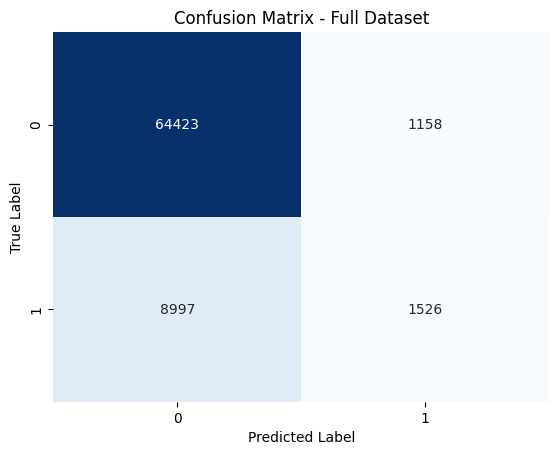

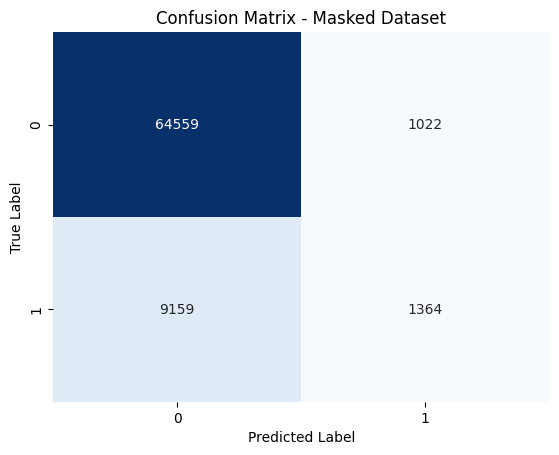

In [33]:
# Calculate confusion matrices for both classifiers
conf_matrix_basic = confusion_matrix(y_test_full, stacking_pred_basic)
conf_matrix_unawareness = confusion_matrix(y_test, stacking_pred_unawareness)

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, title='Confusion Matrix'):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot confusion matrix for the classifier using the full dataset
plot_confusion_matrix(conf_matrix_basic, title='Confusion Matrix - Full Dataset')

# Plot confusion matrix for the classifier with masked sensitive attributes
plot_confusion_matrix(conf_matrix_unawareness, title='Confusion Matrix - Masked Dataset')

In [34]:
def calculate_metrics(conf_matrix):
    TN, FP, FN, TP = conf_matrix.ravel()

    TPR = TP / (TP + FN)  # True Positive Rate
    FPR = FP / (FP + TN)  # False Positive Rate
    FNR = FN / (TP + FN)  # False Negative Rate
    PPV = TP / (TP + FP)  # Positive Predictive Value
    NPV = TN / (TN + FN)  # Negative Predictive Value

    return TPR, FPR, FNR, PPV, NPV

def print_metrics(metrics, model_name):
    TPR, FPR, FNR, PPV, NPV = metrics
    print(f"Metrics for {model_name}:")
    print(f"True Positive Rate (TPR): {TPR:.4f}")
    print(f"False Positive Rate (FPR): {FPR:.4f}")
    print(f"False Negative Rate (FNR): {FNR:.4f}")
    print(f"Positive Predictive Value (PPV): {PPV:.4f}")
    print(f"Negative Predictive Value (NPV): {NPV:.4f}")
    print()

In [35]:
# Calculate metrics for both confusion matrices
metrics_basic = calculate_metrics(conf_matrix_basic)
metrics_unawareness = calculate_metrics(conf_matrix_unawareness)

# Print metrics
print_metrics(metrics_basic, "Basic Classifier")
print_metrics(metrics_unawareness, "Unawareness Classifier")

Metrics for Basic Classifier:
True Positive Rate (TPR): 0.1450
False Positive Rate (FPR): 0.0177
False Negative Rate (FNR): 0.8550
Positive Predictive Value (PPV): 0.5686
Negative Predictive Value (NPV): 0.8775

Metrics for Unawareness Classifier:
True Positive Rate (TPR): 0.1296
False Positive Rate (FPR): 0.0156
False Negative Rate (FNR): 0.8704
Positive Predictive Value (PPV): 0.5717
Negative Predictive Value (NPV): 0.8758



## Model Calibration

### Full Dataset

#### Generate probabilistic predictions:

In [36]:
prob_full = stacking_classifier_basic.predict_proba(X_test_full)[:, 1]  # Probabilities for the positive class

#### Calibration curve:

In [37]:
prob_true_full, prob_pred_full = calibration_curve(y_test_full, prob_full, n_bins=10, strategy='uniform')

#### Calculate the Brier score:

In [38]:
brier_score_full = brier_score_loss(y_test_full, prob_full)
print(f"Brier score for the full dataset model: {brier_score_full:.4f}")

Brier score for the full dataset model: 0.0964


#### Plot calibration plot:

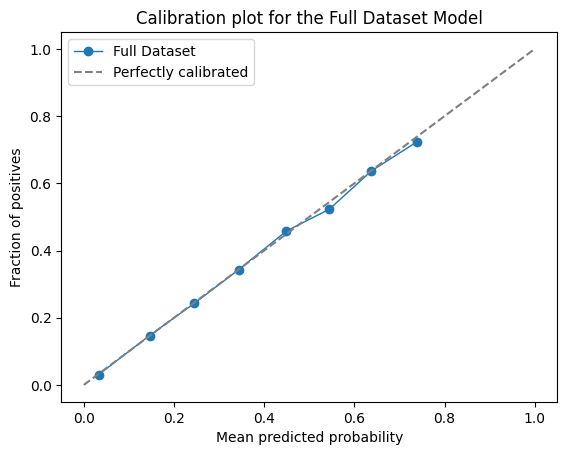

In [39]:
plt.plot(prob_pred_full, prob_true_full, marker='o', linewidth=1, label='Full Dataset')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.title('Calibration plot for the Full Dataset Model')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()

### Masked Dataset

#### Generate probabilistic predictions:

In [40]:
prob_masked = stacking_classifier_unawareness.predict_proba(X_test)[:, 1]

#### Calibration curve:

In [41]:
prob_true_masked, prob_pred_masked = calibration_curve(y_test, prob_masked, n_bins=10, strategy='uniform')

#### Calculate the Brier score:

In [42]:
brier_score_masked = brier_score_loss(y_test, prob_masked)
print(f"Brier score for the masked dataset model: {brier_score_masked:.4f}")

Brier score for the masked dataset model: 0.0981






#### Plot calibration plot:

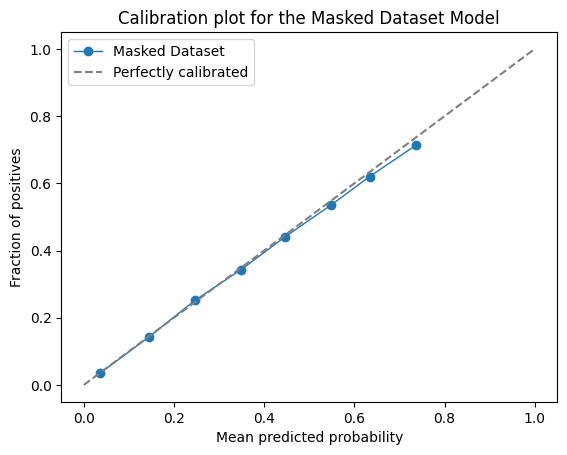

In [43]:
plt.plot(prob_pred_masked, prob_true_masked, marker='o', linewidth=1, label='Masked Dataset')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.title('Calibration plot for the Masked Dataset Model')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()

# Fairness Evaluation

We use the aequitas library to audit our model for unfairness that might be present in the data that reflects in the results of the model's predictions.

In [ ]:
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot
from aequitas import Audit

import math

In [ ]:
def return_audit_df(model_predictions, x_test, y_test):

    predictions_df = pd.DataFrame(data = scaler.inverse_transform(x_test).copy().round().astype(int),
                                  columns = list(x_test.columns))

    predictions_df['label_value'] = y_test.reset_index(drop=True)

    predictions_df['score'] = model_predictions

    df_audit = predictions_df[['Sex', 'Age', 'Education', 'Income', 'label_value', 'score']].copy()

    t_dict = {0:'female', 1:'male'}
    df_audit['Sex'] = df_audit['Sex'].map(lambda x: t_dict[x])

    t_dict = {1:'18-24', 2:'25-29', 3:'30-34', 4:'35-39', 5:'40-44', 6:'45-49', 7:'50-54', 8:'55-59',
              9:'60-64', 10:'65-69', 11:'70-74', 12:'75-79', 13:'80+'}

    df_audit['Age'] = df_audit['Age'].map(lambda x: t_dict[x])

    t_dict = {1:'Kindergarten or less', 2:'Grades 1-8', 3:'Grades 9-11', 4:'High School or GED',
              5:'Some college', 6:'Completed college degree'}

    df_audit['Education'] = df_audit['Education'].map(lambda x: t_dict[x])

    t_dict = {1:'< 10,000', 2:'< 20,000', 3:'< 25,000', 4:'< 30,000', 5: '< 35,000',
              6:'< 45,000', 7:'< 60,000', 8:'< 75,000'}

    df_audit['Income'] = df_audit['Income'].map(lambda x: t_dict[x])


    # Create Group object
    g = Group()

    # Generate crosstabs
    xtab, _ = g.get_crosstabs(df_audit)

    # Compute absolute metrics
    a_m = g.list_absolute_metrics(xtab)

    # Displays crosstab info for confusion matrix metrics + metadata
    return xtab, a_m

In [ ]:
if (run_basic): full_audit_df, absolute_metrics = return_audit_df(stacking_pred_basic, X_test_full, y_test_full)

In [ ]:
def update_audit(audit_df):
    audit_df['Predicted_Positive'] = audit_df['pp'] / (audit_df['pp'] + audit_df['pn'])
    audit_df['Predicted_Negative'] = audit_df['pn'] / (audit_df['pp'] + audit_df['pn'])
    audit_df['True_Label_Positive'] = audit_df['group_label_pos'] / (audit_df['group_label_pos'] + audit_df['group_label_neg'])
    audit_df['True_Label_Negative'] = audit_df['group_label_neg'] / (audit_df['group_label_pos'] + audit_df['group_label_neg'])
    audit_df['group_proportion'] = audit_df['group_size'] / audit_df['total_entities']

    audit_df['Precision'] = audit_df['tp']/(audit_df['tp']+audit_df['fp'])
    audit_df['Recall'] = audit_df['tp']/(audit_df['tp']+audit_df['fn'])

    return audit_df

In [ ]:
if (run_basic): full_audit_df = update_audit(full_audit_df)

In [ ]:
def plot_group_metrics(audit_df, attribute="all", metrics = ['fpr', 'fnr', 'accuracy'], ncols=3, save_name = None):

    the_aqp = Plot()
    if (attribute != "all"):
        plot = the_aqp.plot_group_metric_all(audit_df[audit_df['attribute_name']==attribute],
                                         metrics = metrics,
                                         ncols = ncols)

        if (save_name is not None): plot.savefig(f"{pictures_path}{save_name}.png", dpi=1000, transparent=False)

    else: print("Not implemented yet.")

#### Group Metrics on the Model with Sensitive Attributes Included

In [ ]:
print(list(full_audit_df.columns))

In [ ]:
if (run_basic): plot_group_metrics(full_audit_df,
                                   metrics=['fpr', 'fnr', 'group_proportion',
                                            'accuracy', 'Precision', 'Recall',
                                            'True_Label_Negative', 'True_Label_Positive', 'Predicted_Positive'],
                                   attribute="Age")

In [ ]:
if (run_basic): plot_group_metrics(full_audit_df, "Income")

#### Group Metrics on the Model with Unawareness

In [ ]:
for sensitive_attribute in sensitive_attributes: X_test[sensitive_attribute] = X_test_sensitive[sensitive_attribute]

In [ ]:
unawareness_audit_df, absolute_metrics = return_audit_df(stacking_pred_unawareness, X_test, y_test)

In [ ]:
unawareness_audit_df = update_audit(unawareness_audit_df)

In [ ]:
plot_group_metrics(unawareness_audit_df, attribute="Age",
                   metrics=['fnr', 'fpr', 'accuracy',
                            'Predicted_Positive', 'Predicted_Negative', 'group_proportion'],
                   ncols=3,
                   save_name=None)
#                    save_name="Aequitas_Age_")

In [ ]:
def cm_percent_of_true_label(y_labels, model_test_y, title="", save_name = None):

    confusion_matrix = metrics.confusion_matrix(y_labels, model_test_y)
    cm_percent = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis] * 100
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_percent)

    cm_display.plot(cmap='Blues')
    plt.title(title)
    if (save_name is not None): plt.savefig(f"{pictures_path}{save_name}.png", dpi=1000, transparent=True)
    plt.show()

In [ ]:
cm_percent_of_true_label(y_test, stacking_pred_unawareness,
                         "Confusion Matrix for Model with Simulated Training Data",
#                         save_name=None)
                        save_name = "CM_Oversample_and_Undersample")

# Mitigating Bias

#### Threshold Calibration Function

In [44]:
def threshold_calibration(predictions, true_labels, threshold):
    """
    Perform threshold calibration manually.

    Parameters:
        predictions (array-like): Predicted probabilities or scores.
        true_labels (array-like): True binary labels (0 or 1).
        threshold (float): Threshold value for binary classification.

    Returns:
        calibrated_predictions (array-like): Calibrated binary predictions.
    """
    calibrated_predictions = (predictions >= threshold).astype(int)
    return calibrated_predictions

Calibrating Fairness through Unawareness Bias

In [45]:
predictions = stacking_pred_unawareness
true_labels = y_test
threshold = 0.5

calibrated_predictions = threshold_calibration(predictions, true_labels, threshold)

We perform the threshold calibration on the predictions we gained after using fairness through unawareness to drop protected information from the data.

#### Confusion Matrix

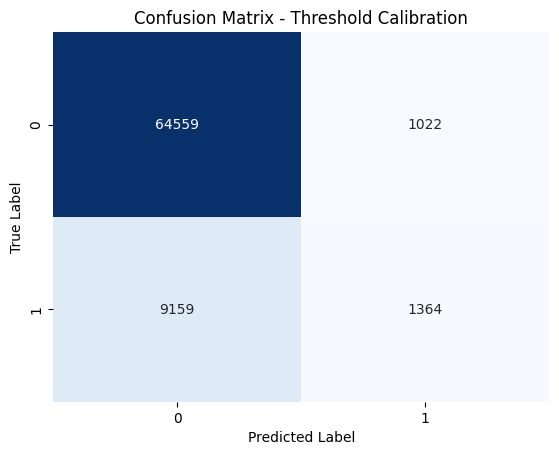

Metrics for Post Calibration Metrics:
True Positive Rate (TPR): 0.1296
False Positive Rate (FPR): 0.0156
False Negative Rate (FNR): 0.8704
Positive Predictive Value (PPV): 0.5717
Negative Predictive Value (NPV): 0.8758



In [46]:
conf_matrix_calibrated = confusion_matrix(true_labels, calibrated_predictions)

plot_confusion_matrix(conf_matrix_calibrated, "Confusion Matrix - Threshold Calibration")
metrics_calibrated = calculate_metrics(conf_matrix_calibrated)
print_metrics(metrics_calibrated, "Post Calibration Metrics")

We see through the use of threshold calibration that our metrics have changed. The True Positive Rate increased slightly as well as the False Positive Rate. False Negative Rate also decreased. PPV decreased while NPV increased. While there appears to be slight reductions in bias it also comes with a decrease in the accuracy of the model and the overall reduction to bias is not largely significant through the post processing technique.